### ***using on B4-4/VQA_Demo

In [82]:
import os

# proxyの設定．
# keras.datasetsでは，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"

# Visual Question Answering Demo and Tutorial

This is an online demo with explanation and tutorial on Visual Question Answering. This is no not a naive or hello-world model, this model returns close to state-of-the-art without using any attention models, memory networks (other than LSTM) and fine-tuning, which are essential recipe for current best results.

I have tried to explain different parts, and their choices. This is meant to be an interactive tutorial, feel free to change the model parameters and experiment. If you have latest graphics card, execution time should be within a minute.

All the files required to run this ipython notebook can be obtained from 
### <https://github.com/iamaaditya/VQA_Demo>

## Load the libraries

In [1]:
%matplotlib inline
import os, argparse
import cv2, spacy, numpy as np
from keras.models import model_from_json
from keras.optimizers import SGD
from sklearn.externals import joblib
from keras import backend as K
from keras.utils.vis_utils import plot_model
K.set_image_data_format('channels_first')
#K.set_image_dim_ordering('th')

Using TensorFlow backend.
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Load the models and weights files
This does not load the models yet, but we are providing the files


In [66]:
# File paths for the model, all of these except the CNN Weights are 
# provided in the repo, See the models/CNN/README.md to download VGG weights
VQA_model_file_name      = 'models/VQA/VQA_MODEL.json'
VQA_weights_file_name   = 'models/VQA/VQA_MODEL_WEIGHTS.hdf5'
label_encoder_file_name  = 'models/VQA/FULL_labelencoder_trainval.pkl'
CNN_weights_file_name   = 'models/CNN/vgg16_weights.h5'


## Model Idea
This uses a classical CNN-LSTM  model like shown below, where Image features and language features are computed separately and combined together and a multi-layer perceptron is trained on the combined features.

Similar models have been presented at following links, this work takes ideas from them.
1. <https://github.com/abhshkdz/neural-vqa>
2. <https://github.com/avisingh599/visual-qa>
3. https://github.com/VT-vision-lab/VQA_LSTM_CNN


<img src="http://i.imgur.com/Za5P1ZZ.png">
[Source](http://arxiv.org/pdf/1505.00468v4.pdf)

# Image features 

## Pretrained VGG Net (VGG-16)

While VGG Net is not the best CNN model for image features, GoogLeNet (winner 2014) and ResNet (winner 2015) have superior classification scores, but VGG Net is very versatile, simple, relatively small and more importantly portable to use. 

For reference here is the VGG 16 performance on ILSVRC-2012
<img src="http://www.robots.ox.ac.uk/~vgg/research/very_deep/images/table_ILSVRC.png">

## Compile the model

In [49]:
def get_image_model(CNN_weights_file_name):
    ''' Takes the CNN weights file, and returns the VGG model update 
    with the weights. Requires the file VGG.py inside models/CNN '''
    from models.CNN.VGG import VGG_16, pop
    image_model = VGG_16(CNN_weights_file_name)
    image_model = Sequential(image_model.layers[:-2]) # Get rid of the classification layer

    # this is standard VGG 16 without the last two layers
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # one may experiment with "adam" optimizer, but the loss function for
    # this kind of task is pretty standard
    image_model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return image_model

## Plot the Model

Keras has a function which allows you to visualize the model in block diagram. Let's do it !

In [32]:
#escape from error
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


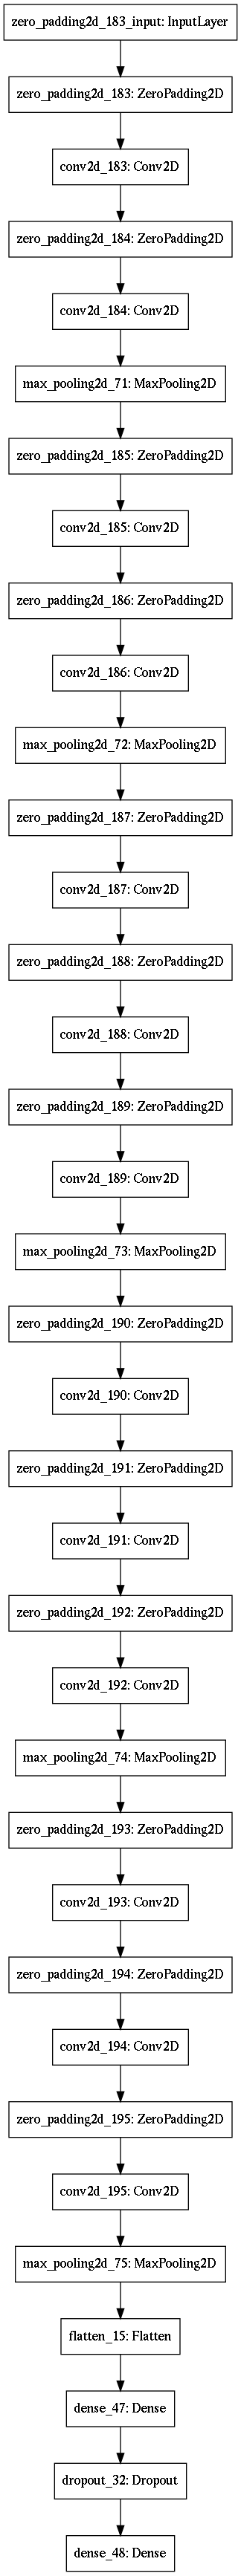

In [50]:
model_vgg = get_image_model(CNN_weights_file_name)
plot_model(model_vgg, to_file='model_vgg.png')

<img src="model_vgg.png">

## Extract Image features


Extracting image features involves, taking a raw image, and running it through the model, until we reach the last layer. In this case our model is not 100% same as VGG Net, because we are not going to use the last two layer of the VGG. It is because the last layer of VGG Net is a 1000 way softmax and the second last layer is the Dropout.

Thus we are extracting the 4096 Dimension image features from VGG-16


In [6]:
def get_image_features(image_file_name):
    ''' Runs the given image_file to VGG 16 model and returns the 
    weights (filters) as a 1, 4096 dimension vector '''
    image_features = np.zeros((1, 4096))
    # Magic_Number = 4096  > Comes from last layer of VGG Model

    # Since VGG was trained as a image of 224x224, every new image
    # is required to go through the same transformation
    im = cv2.resize(cv2.imread(image_file_name), (224, 224))
    im = im.transpose((2,0,1)) # convert the image to RGBA

    
    # this axis dimension is required because VGG was trained on a dimension
    # of 1, 3, 224, 224 (first axis is for the batch size
    # even though we are using only one image, we have to keep the dimensions consistent
    im = np.expand_dims(im, axis=0) 
    print(model_vgg.predict(im).shape)
    image_features[0,:] = model_vgg.predict(im)[0]
    return image_features

# Word Embeddings

The question has to be converted into some form of word embeddings. Most popular is Word2Vec whereas these days state of the art uses [skip-thought vectors](https://github.com/ryankiros/skip-thoughts) or [positional encodings](https://en.wikipedia.org/wiki/Encoding_(memory).

We will use Word2Vec from Stanford called [Glove](http://nlp.stanford.edu/projects/glove/). Glove reduces a given token into a 300 dimensional representation.

In [7]:
def get_question_features(question):
    ''' For a given question, a unicode string, returns the time series vector
    with each word (token) transformed into a 300 dimension representation
    calculated using Glove Vector '''
    word_embeddings = spacy.load('en_core_web_lg')
    tokens = word_embeddings(question)
    question_tensor = np.zeros((1, 30, 300))
    for j in range(len(tokens)):
        question_tensor[0,j,:] = tokens[j].vector
    return question_tensor

## Try the embeddings

Let's see the embeddings, and their usage with sample words like this -
1. Obama 
2. Putin
3. Banana
4. Monkey

In [8]:
word_embeddings = spacy.load('en_core_web_lg')

In [9]:
obama = word_embeddings(u"obama")
putin = word_embeddings(u"putin")
banana = word_embeddings(u"banana")
monkey = word_embeddings(u"monkey")

In [10]:
obama.similarity(putin)

0.43514112534149385

In [11]:
obama.similarity(banana)

0.17831367341230245

In [12]:
banana.similarity(monkey)

0.45207788279447625

As we can see, obama and putin are very similar in representation than obama and banana. This shows you there is some semantic knowledge of the tokens embedded in the 300 dimensional representation. We can do cool arithmatics with these word2vec like 'Queen' - 'King' + 'Boy' = 'Girl'. See [this blog post](http://multithreaded.stitchfix.com/blog/2015/03/11/word-is-worth-a-thousand-vectors/) for more details.

## VQA Model

VQA is a simple model which combines features from Image and Word Embeddings and runs a multiple layer perceptron.

In [13]:
import keras
from keras.models import Sequential, Model
from keras.layers.core import Reshape, Activation, Dropout
from keras.layers import LSTM, concatenate, Dense

def VQA_MODEL():
    image_feature_size          = 4096
    word_feature_size           = 300
    number_of_LSTM              = 3
    number_of_hidden_units_LSTM = 512
    max_length_questions        = 30
    number_of_dense_layers      = 3
    number_of_hidden_units      = 1024
    activation_function         = 'tanh'
    dropout_pct                 = 0.5


    # Image model
    model_image = Sequential()
    model_image.add(Reshape((image_feature_size,), input_shape=(image_feature_size,)))

    # Language Model
    model_language = Sequential()
    model_language.add(LSTM(number_of_hidden_units_LSTM, return_sequences=True, input_shape=(max_length_questions, word_feature_size)))
    model_language.add(LSTM(number_of_hidden_units_LSTM, return_sequences=True))
    model_language.add(LSTM(number_of_hidden_units_LSTM, return_sequences=False))

    # combined model
    model = concatenate([model_language.output, model_image.output], axis=-1)
    
    #model = Model(inputs=[model_language.input, model_image.input],outputs=model)
    for _ in range(number_of_dense_layers):
        model = Dense(number_of_hidden_units, kernel_initializer='uniform')(model)
        model = Activation(activation_function)(model)
        model = Dropout(dropout_pct)(model)

    model = Dense(1000)(model)
    model = Activation('softmax')(model)
    model = Model(inputs=[model_language.input, model_image.input],outputs=model)
    return model

In [14]:
def get_VQA_model(VQA_model_file_name, VQA_weights_file_name):
    ''' Given the VQA model and its weights, compiles and returns the model '''

    # thanks the keras function for loading a model from JSON, this becomes
    # very easy to understand and work. Alternative would be to load model
    # from binary like cPickle but then model would be obfuscated to users
    #vqa_model = model_from_json(open(VQA_model_file_name).read())
    vqa_model = VQA_MODEL()
    vqa_model.load_weights(VQA_weights_file_name)
    vqa_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return vqa_model

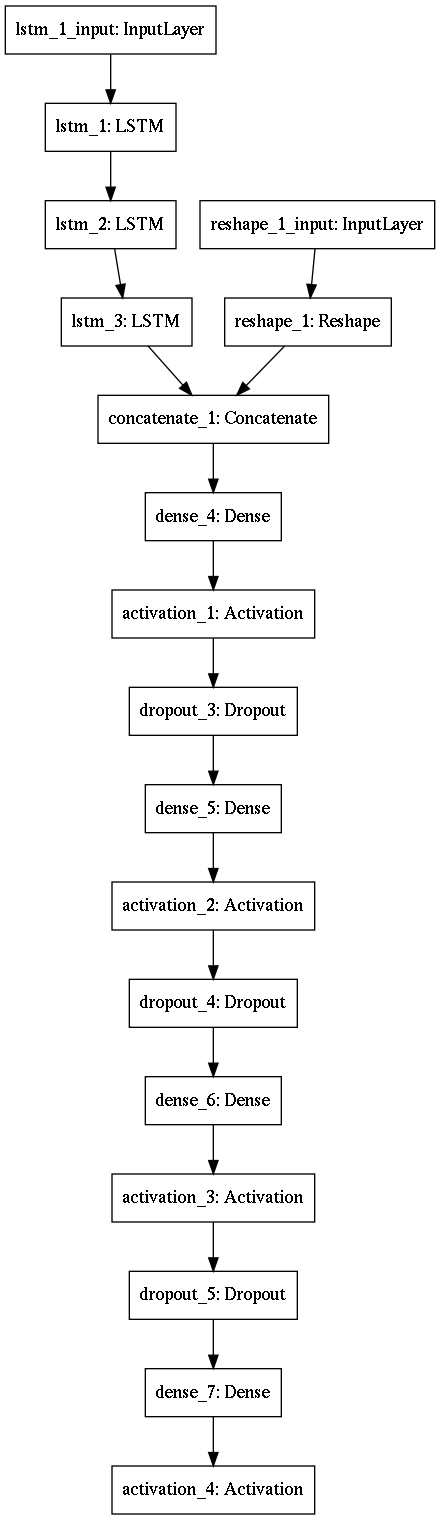

In [15]:
model_vqa = get_VQA_model(VQA_model_file_name, VQA_weights_file_name)
plot_model(model_vqa, to_file='model_vqa.png')

<img src="model_vqa.png">

As it can be seen above the model also runs a 3 layered LSTM on the word embeddings. To get a naive result it is sufficient to feed the word embeddings directly to the merge layer, but as mentioned above model is gives close to the state-of-the-art results.

Also, four layers of fully connected layers might not be required to achieve a good enough results. But I settled on this model after some experimentation, and their results beat few layers. 

## Asketh Away !

Let's give a test image and a question

In [16]:
image_file_name = 'test.jpg'
question = u"What vehicle is in the picture?"

# <center> What vehicle is in the picture ? </center>

<img src="test.jpg">

In [51]:
# get the image features
image_features = get_image_features(image_file_name)

(1, 4096)


In [18]:
# get the question features
question_features = get_question_features(question)

In [81]:
y_output = model_vqa.predict([question_features, image_features])

# This task here is represented as a classification into a 1000 top answers
# this means some of the answers were not part of training and thus would 
# not show up in the result.
# These 1000 answers are stored in the sklearn Encoder class
labelencoder = joblib.load(label_encoder_file_name)
#esc error
import numpy
x = numpy.load("models/VQA/FULL_labelencoder_trainval.pkl_01.npy")

for label in reversed(np.argsort(y_output)[0,-5:]):
    print(str(round(y_output[0,label]*100,2)).zfill(5), "% ",x[label])

35.92 %  bus
23.32 %  truck
09.07 %  motorcycle
08.43 %  bicycle
05.05 %  piano


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The file 'models/VQA/FULL_labelencoder_trainval.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  import sys
